In [ ]:
##################################
# Part of the codes refer to Kaggle
##################################

# EEG

In [ ]:
!pip install pyod
import os
import numpy as np
from pyod.models import hbos
from pyod.utils.data import evaluate_print
from sklearn.metrics import confusion_matrix,cohen_kappa_score,f1_score
from scipy import signal
import matplotlib.pyplot as plt
import pickle
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=e511e3ed9469e7ee407d31f7ff541f17b935e051398dd5317cf1f3176e8d7546
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


In [ ]:
pip install auraloss

In [ ]:
#####
# Trial or epoch = eeg segment
#####

channels = 32
seconds = 0.5    # Size of each segment we want
fs = 256.0         # Dtaset eeg sampling rate
data_portion = 1
save_model = False

In [ ]:
class EEGDataset2:
    def __init__(self, train_csv, seconds=0.500, fs=256, data_portion=1, normalize=True, isolated_channels=False):
        assert data_portion > 0.0 and data_portion <= 1, 'data_portion should be > 0 and <= 1'

        self.isolated_channels = isolated_channels
        self.normalize = normalize
        self.train_csv = train_csv
        self.seconds = seconds
        self.fs = fs
        self.data_portion = data_portion

    def get_data(self):
        df = pd.read_csv(self.train_csv)
        array_size = int(self.seconds * self.fs)
        # Dataset shape is: [data x channels]
        # we want shape: [segments x features]

        if self.normalize:
            df = (df - df.mean()) / df.std()

        if self.isolated_channels:
            channels = []
            for channel in df.columns[0:32]:
                isolated_channel = []
                for i in range(int(len(df) / array_size)):
                    isolated_channel.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())
                channels.append(np.array(isolated_channel))
            return np.array(channels)

        dataset = []

        for channel in df.columns[0:32]:
            for i in range(int(len(df) / array_size)):
                dataset.append(df[channel][i*array_size:(i+1)*array_size].to_numpy())

        return np.array(dataset)

In [ ]:
data = pd.read_csv('emotions.csv')
data

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.620,30.3,-356.0,15.60,26.3,1.070,0.411,-15.700,2.060,3.15,...,23.50,20.300,20.300,23.50,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.800,33.1,32.0,25.80,22.8,6.550,1.680,2.880,3.830,-4.82,...,-23.30,-21.800,-21.800,-23.30,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.900,29.4,-416.0,16.70,23.7,79.900,3.360,90.200,89.900,2.03,...,462.00,-233.000,-233.000,462.00,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.900,31.6,-143.0,19.80,24.3,-0.584,-0.284,8.820,2.300,-1.97,...,299.00,-243.000,-243.000,299.00,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.300,31.3,45.2,27.30,24.5,34.800,-5.790,3.060,41.400,5.52,...,12.00,38.100,38.100,12.00,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,32.400,32.2,32.2,30.80,23.4,1.640,-2.030,0.647,-0.121,-1.10,...,-21.70,0.218,0.218,-21.70,95.2,-19.90,47.20,47.20,-19.90,NEUTRAL
2128,16.300,31.3,-284.0,14.30,23.9,4.200,1.090,4.460,4.720,6.63,...,594.00,-324.000,-324.000,594.00,-35.5,142.00,-59.80,-59.80,142.00,POSITIVE
2129,-0.547,28.3,-259.0,15.80,26.7,9.080,6.900,12.700,2.030,4.64,...,370.00,-160.000,-160.000,370.00,408.0,-169.00,-10.50,-10.50,-169.00,NEGATIVE
2130,16.800,19.9,-288.0,8.34,26.0,2.460,1.580,-16.000,1.690,4.74,...,124.00,-27.600,-27.600,124.00,-656.0,552.00,-271.00,-271.00,552.00,NEGATIVE


In [ ]:
df = pd.read_csv('emotions.csv')

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
#importing Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
tf.keras.backend.clear_session()

#!pip install --upgrade scikit-learn
from sklearn import datasets, tree, linear_model, svm
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
def Transform_data(data):
    #Encoding Lables into numbers
    encoding_data = ({'NEUTRAL': 1, 'POSITIVE': 2, 'NEGATIVE': 0} )
    data_encoded = data.replace(encoding_data)
    #getting brain signals into x variable
    x = data_encoded.drop(["label"]  ,axis=1)
    #getting labels into y variable
    y = data_encoded.loc[:,'label'].values
    scaler = StandardScaler()
    #scaling Brain Signals
    scaler.fit(x)
    X = scaler.transform(x)
    #One hot encoding Labels
    Y = to_categorical(y)
    return X,Y

In [ ]:
#Calling above function and splitting dataset into train and test
X, Y = Transform_data(data)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 4)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1705, 2548), (1705, 3), (427, 2548), (427, 3))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1705, 2548, 1), (1705, 3), (427, 2548, 1), (427, 3))


Adjusting input for EEG and Audio signals

In [ ]:
x_train_eeg = x_train
y_train_eeg = y_train
x_test_eeg = x_test
y_test_eeg = y_test

In [ ]:
x_train_eeg2 = x_train[:, :162]
x_test_eeg2 = x_test[:, :162]

# TCN -- emotion EEG

In [ ]:
##############
# TCN
##############

def t_softmax(x, temperature=1.0):
    x = x / temperature
    return tf.keras.activations.softmax(x)

def ResidualBlock(x, filters, kernel_size, dilation_rate):
    residual = x  # Save input values for later skip connections

    # First convolutional layer
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Second convolutional layer
    x = tf.keras.layers.Conv1D(filters, kernel_size, padding='causal', dilation_rate=dilation_rate)(x)
    x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # If the shapes don't match, use a 1x1 convolution to adjust the shape of the residual.
    if residual.shape[-1] != x.shape[-1]:
      residual = tf.keras.layers.Conv1D(filters, 1, padding='same')(residual)
    # Skip connection
    x = tf.keras.layers.Add()([x, residual])  # Add the original input (residual) to the convolutional layer output

    return x

def create_model(temperature=1.0):

    inputs = tf.keras.Input(shape=(x_train.shape[1],))
    #The tf.expand_dims function adds dimensions to the input data.
    #It adds a new dimension to the second dimension (axis=2) to prepare the data for the 1-d convolutional layer.
    expand_dims = tf.expand_dims(inputs, axis=2)

    x = ResidualBlock(expand_dims, 128, 7, 1)
    x = ResidualBlock(x, 64, 5, 2)
    x = ResidualBlock(x, 32, 3, 4)
    x = ResidualBlock(x, 16, 3, 8)


    #Fully Connected Layer: Spreads multi-dimensional convolutional output to one dimension
    x = tf.keras.layers.Flatten()(x)

    #Dropout regularization with a dropout rate of 0.7 to prevent overfitting
    x = tf.keras.layers.Dropout(0.7)(x)

    #A dense fully connected layer was added with an output dimension of 3,
    #which typically corresponds to the number of categories in a classification task.
    #A softmax activation function is used, allowing the output to be interpreted as a probability distribution.
    outputs = tf.keras.layers.Dense(3)(x)
    outputs = tf.keras.layers.Activation(lambda x: t_softmax(x, temperature=temperature))(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
#cretaing model
temperature = 10  # Example value, adjust based on experimentation
tcnmodel = create_model(temperature)

#Compiling model
#The compile method of tcnmodel is called to configure the training process.
#The optimizer is AdamW, a variant of the Adam optimizer that includes weight_decay
#The learning rate was set to 0.0001. The loss function was set to categorical_crossentropy,
# which is commonly used for multi-class classification problems
#Evaluation indicators include mean absolute error (mae) and accuracy (accuracies)
tcnmodel.compile(
    optimizer= tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-4),
    loss='categorical_crossentropy',
    metrics=['mae', 'accuracy']
)

print(tcnmodel.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2548)]               0         []                            
                                                                                                  
 tf.expand_dims_1 (TFOpLamb  (None, 2548, 1)              0         ['input_2[0][0]']             
 da)                                                                                              
                                                                                                  
 conv1d_12 (Conv1D)          (None, 2548, 128)            1024      ['tf.expand_dims_1[0][0]']    
                                                                                                  
 p_re_lu_8 (PReLU)           (None, 2548, 128)            326144    ['conv1d_12[0][0]']     

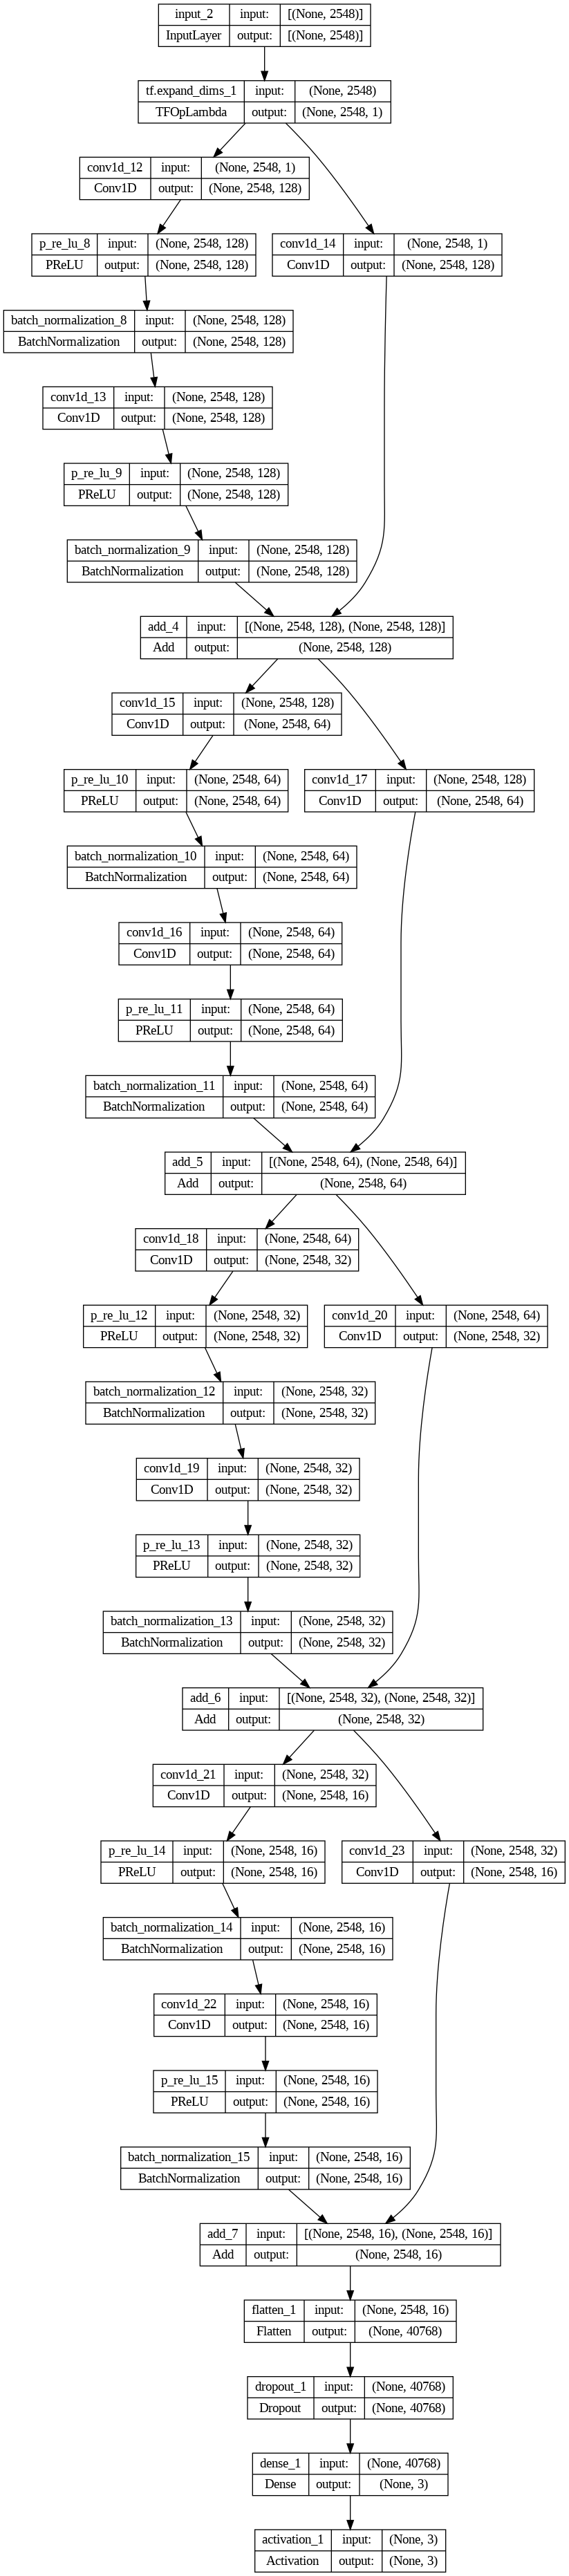

In [ ]:
dot_img_file = 'TCN.png'
tf.keras.utils.plot_model(tcnmodel, to_file=dot_img_file, show_shapes=True)

In [ ]:
#Training and Evaluting model
#EarlyStopping, which monitors the loss values of the model during training and stops training
#if the loss does not improve in 10 consecutive cycles (patience=10).
# The fit method starts training the model. The training is performed for 50 cycles (epochs=50).
#20% of the training data is used as a validation set at the end of each cycle (validation_split=0.2).
#At the same time, the early stop callbacks defined earlier are added to the training process.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience = 10)
history = tcnmodel.fit(x_train, y_train, epochs = 50, validation_split=0.2, callbacks= [callback])
loss, mae, acc = tcnmodel.evaluate(x_test, y_test)

Epoch 1/50
43/43 [==============================] - 23s 167ms/step - loss: 0.3838 - mae: 0.1579 - accuracy: 0.8636 - val_loss: 0.9513 - val_mae: 0.4025 - val_accuracy: 0.5367
Epoch 2/50
43/43 [==============================] - 5s 114ms/step - loss: 0.1485 - mae: 0.0657 - accuracy: 0.9538 - val_loss: 0.9485 - val_mae: 0.3776 - val_accuracy: 0.4106
Epoch 3/50
43/43 [==============================] - 4s 104ms/step - loss: 0.1054 - mae: 0.0495 - accuracy: 0.9633 - val_loss: 0.9215 - val_mae: 0.3568 - val_accuracy: 0.4076
Epoch 4/50
43/43 [==============================] - 5s 106ms/step - loss: 0.0786 - mae: 0.0386 - accuracy: 0.9714 - val_loss: 0.7594 - val_mae: 0.3182 - val_accuracy: 0.5191
Epoch 5/50
43/43 [==============================] - 5s 112ms/step - loss: 0.0559 - mae: 0.0281 - accuracy: 0.9861 - val_loss: 0.6028 - val_mae: 0.2673 - val_accuracy: 0.7361
Epoch 6/50
43/43 [==============================] - 5s 112ms/step - loss: 0.0367 - mae: 0.0205 - accuracy: 0.9941 - val_loss: 0.4

In [ ]:
#Loss and Accuracy of model on Testing Dataset
print(f"Loss on testing dataset: {loss}",f"\nAccuracy on Testing: {acc*100}")

Loss on testing dataset: 0.011974524706602097 
Accuracy on Testing: 99.53161478042603


In [ ]:
#predicting model on test set for plotting Confusion Matrix
pred  = tcnmodel.predict(x_test)

14/14 [==============================] - 1s 34ms/step


In [ ]:
#after getting prediction checking maximum score prediction to claim which emotion this brain signal belongs to
pred1 = np.argmax(pred,axis=1)
pred1

array([2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0,
       1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0,
       0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2,
       1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 0, 1,
       2, 0, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2,
       1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0, 2, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1,
       2, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2,
       1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 2, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 2,

In [ ]:
#inversing the one hot encoding
y_test1 = np.argmax(y_test,axis=1)
y_test1

array([2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 0, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 2, 1, 0, 0,
       1, 0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0,
       0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2,
       1, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2,
       1, 2, 2, 0, 2, 1, 2, 2, 0, 0, 1, 0, 2, 1, 0, 0, 1, 2, 1, 0, 0, 1,
       2, 0, 0, 0, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 0, 2, 2, 2, 1, 0, 2, 2,
       1, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 0, 2, 2, 1, 0, 2, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 2, 1,
       2, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 2, 2,
       2, 1, 1, 1, 1, 0, 1, 2, 0, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 1, 1, 2,
       1, 2, 2, 2, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 2, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 0, 0, 2,

In [ ]:
#Creation of Function of Confusion Matrix
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(data.label.unique()))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[132   0   0]
 [  0 152   1]
 [  1   0 141]]


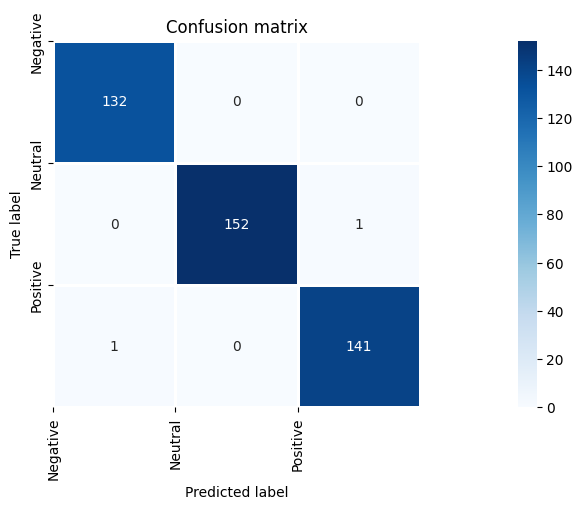

In [ ]:
#Plotting Confusion matrix of Lstm Model
cm = confusion_matrix(y_test1, pred1)
np.set_printoptions(precision=2)
print(cm)
plt.rcParams["figure.figsize"]=(20,5)
plt.figure()
plot_confusion_matrix(cm,["Negative","Neutral","Positive"])

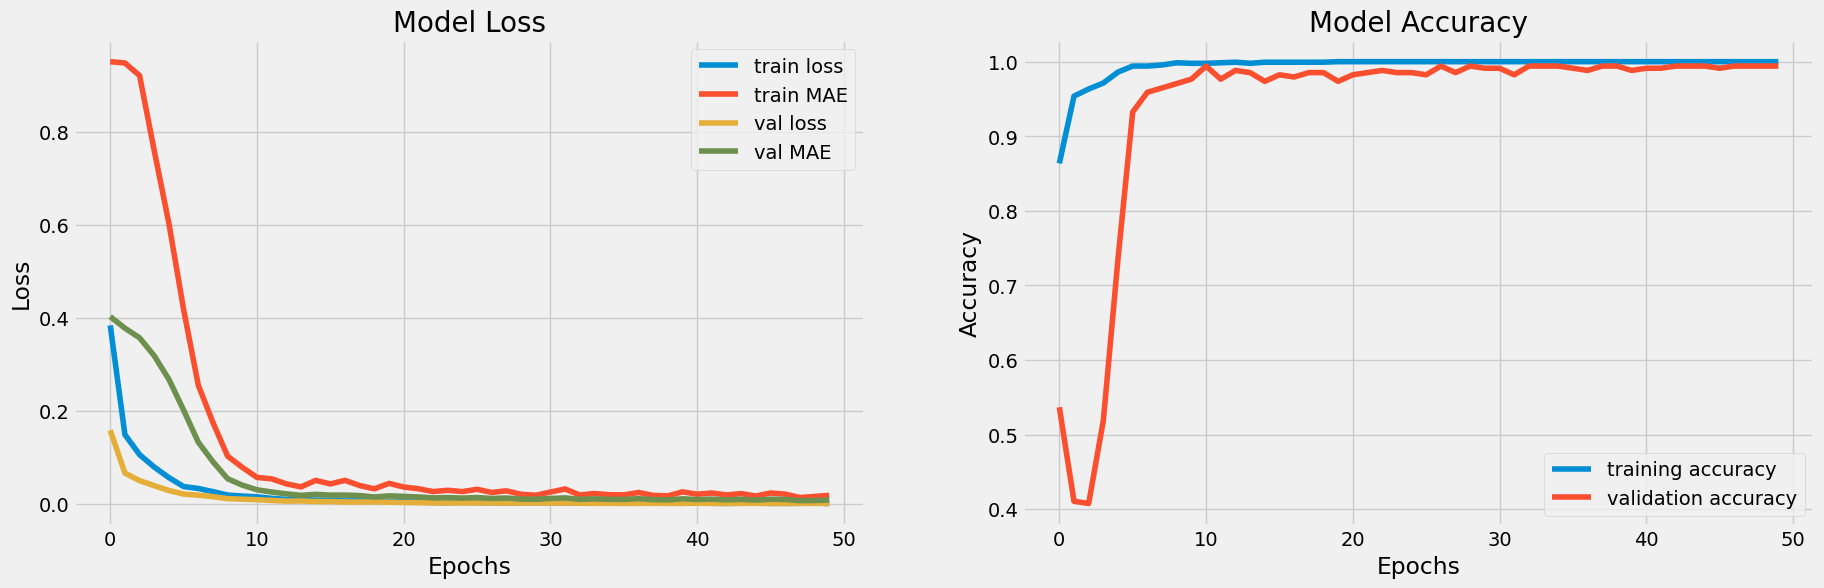

In [ ]:
#Plotting Graph of CNN model Training, Loss and Accuracy
plt.style.use("fivethirtyeight")
plt.figure(figsize = (20,6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title("Model Loss",fontsize=20)
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train loss', 'train MAE', 'val loss', 'val MAE'], loc ='best')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy",fontsize=20)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training accuracy', 'validation accuracy'], loc ='best')
plt.show()